## Performance Comparison of `torch.einsum` and `opt_einsum`*

### *Why Compare?*

When working with large tensors and complex contraction patterns, the performance of tensor contraction operations can significantly impact the overall efficiency of your code. `torch.einsum` and `opt_einsum` are two popular libraries for tensor contractions, but they have different optimization strategies and performance characteristics. By comparing their performance, you can choose the best library for your specific use case and optimize your code for better performance.

### *Comparison Example*
#### Contraction Pattern
   $$\sum_{n=1}^{N} \sum_{h=1}^{H} \sum_{m=1}^{M} A_{hmn} B_{hn} = C_{hm}$$
   - e.g, `hmn,hn->hm`

#### Tensor Size
   - $H \in \{3, 10, 30, 100, 300, 1000\}$
   - $M \in \{4, 10, 30, 100, 300, 1000\}$
   - $N \in \{4, 10, 30, 100, 300, 1000\}$
#### Iteration
   -  1000




In [1]:
import timeit
import torch
from opt_einsum import contract


# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Define the tensor sizes
H_values = [3, 10, 30, 100, 300, 1000]
N_values = [4, 10, 30, 100, 300, 1000]
iterations = 1000
contraction_pattern = "hmn,hn->hm"

# Initialize the timing results
torch_einsum_cpu_times = []
opt_einsum_cpu_times = []
torch_einsum_gpu_times = []
opt_einsum_gpu_times = []

for H, N in zip(H_values, N_values):
    A = torch.randn(H, N, N)
    B = torch.randn(H, N)

    # CPU test
    torch_einsum_cpu_time = timeit.timeit(
        lambda: torch.einsum(contraction_pattern, A, B),
        number=iterations
    )
    opt_einsum_cpu_time = timeit.timeit(
        lambda: contract(contraction_pattern, A, B),
        number=iterations
    )
    torch_einsum_cpu_times.append(torch_einsum_cpu_time)
    opt_einsum_cpu_times.append(opt_einsum_cpu_time)

    # GPU test if CUDA is available
    if use_cuda:
        A_gpu = A.cuda()
        B_gpu = B.cuda()
        torch_einsum_gpu_time = timeit.timeit(
            lambda: torch.einsum(contraction_pattern, A_gpu, B_gpu),
            number=iterations
        )
        opt_einsum_gpu_time = timeit.timeit(
            lambda: contract(contraction_pattern, A_gpu, B_gpu),
            number=iterations
        )
        torch_einsum_gpu_times.append(torch_einsum_gpu_time)
        opt_einsum_gpu_times.append(opt_einsum_gpu_time)
    else:
        torch_einsum_gpu_times.append(float('inf'))
        opt_einsum_gpu_times.append(float('inf'))



/Users/joseph/miniconda3/envs/sssd/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


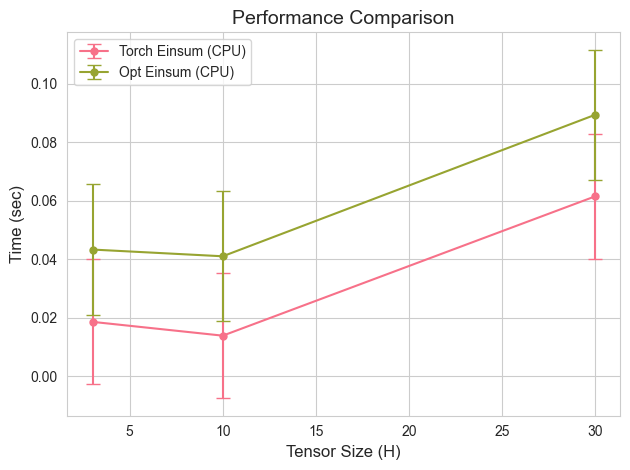

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


torch_einsum_cpu_std = np.std(torch_einsum_cpu_times)
opt_einsum_cpu_std = np.std(opt_einsum_cpu_times)
torch_einsum_gpu_std = np.std(torch_einsum_gpu_times)
opt_einsum_gpu_std = np.std(opt_einsum_gpu_times)

# Set Seaborn style
sns.set_style("whitegrid")

# Define colors
colors = sns.color_palette("husl", 4)

# Plot with error bars
plt.errorbar(
    x=H_values,
    y=torch_einsum_cpu_times,
    yerr=torch_einsum_cpu_std,
    label='Torch Einsum (CPU)',
    capsize=5,
    fmt='-o',
    markersize=5,
    color=colors[0]
)
plt.errorbar(
    x=H_values,
    y=opt_einsum_cpu_times,
    yerr=opt_einsum_cpu_std,
    label='Opt Einsum (CPU)',
    capsize=5,
    fmt='-o',
    markersize=5,
    color=colors[1]
)

if use_cuda:
    plt.errorbar(
        x=H_values,
        y=torch_einsum_gpu_times,
        yerr=torch_einsum_gpu_std,
        label='Torch Einsum (GPU)',
        capsize=5,
        fmt='-o',
        markersize=5,
        color=colors[2]
    )
    plt.errorbar(
        x=H_values,
        y=opt_einsum_gpu_times,
        yerr=opt_einsum_gpu_std,
        label='Opt Einsum (GPU)',
        capsize=5,
        fmt='-o',
        markersize=5,
        color=colors[3]
    )

# Add labels and title
plt.xlabel('Tensor Size (H)', fontsize=12)
plt.ylabel('Time (sec)', fontsize=12)
plt.title('Performance Comparison', fontsize=14)

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
